In [ ]:
# Unzip the uploaded file and extract all contents
!unzip -q /content/imageone.zip -d /content/extracted_folder/

# Display the list of files in the extracted folder
import os

# Walk through the extracted directory and print all files
for root, dirs, files in os.walk("/content/extracted_folder/"):
    for file in files:
        print(os.path.join(root, file))


/content/extracted_folder/dataset1/valid/woman/face_331.jpg
/content/extracted_folder/dataset1/valid/woman/face_245.jpg
/content/extracted_folder/dataset1/valid/woman/face_225.jpg
/content/extracted_folder/dataset1/valid/woman/face_314.jpg
/content/extracted_folder/dataset1/valid/woman/face_358.jpg
/content/extracted_folder/dataset1/valid/woman/face_255.jpg
/content/extracted_folder/dataset1/valid/woman/face_192.jpg
/content/extracted_folder/dataset1/valid/woman/face_302.jpg
/content/extracted_folder/dataset1/valid/woman/face_272.jpg
/content/extracted_folder/dataset1/valid/woman/face_370.jpg
/content/extracted_folder/dataset1/valid/woman/face_315.jpg
/content/extracted_folder/dataset1/valid/woman/face_329.jpg
/content/extracted_folder/dataset1/valid/woman/face_367.jpg
/content/extracted_folder/dataset1/valid/woman/face_239.jpg
/content/extracted_folder/dataset1/valid/woman/face_234.jpg
/content/extracted_folder/dataset1/valid/woman/face_311.jpg
/content/extracted_folder/dataset1/valid

In [ ]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import cv2

def preprocess_image(image_path):
    # Open the image
    image = Image.open(image_path)

    # Adjust Brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)  # Slight increase in brightness

    # Adjust Contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Increase contrast

    # Adjust Sharpness
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(2.0)  # Increase sharpness

    # Convert image to OpenCV format for further processing
    open_cv_image = np.array(image)

    # Convert RGB to BGR for OpenCV compatibility
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # Apply a Gaussian Blur if the image is too sharp or noisy
    blurred_image = cv2.GaussianBlur(open_cv_image, (5, 5), 0)

    # Convert back to RGB
    preprocessed_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

    return Image.fromarray(preprocessed_image)

# Example usage:
# preprocessed_image = preprocess_image('path_to_your_image.jpg')
# preprocessed_image.show()


In [ ]:
preprocessed_image = preprocess_image('/content/extracted_folder/dataset1/train/man/face_1000.jpg')
preprocessed_image.show()

# KNN

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
KNN Model Accuracy: 76.88%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       160
           1       0.75      0.81      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320



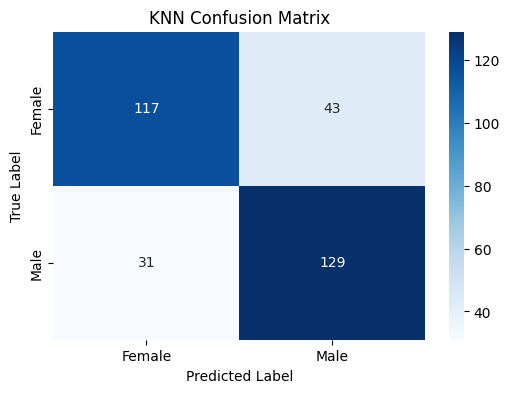

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing the dataset using ImageDataGenerator
def load_and_preprocess_data(data_dir):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2  # Splitting dataset into 80% training and 20% validation
    )

    # Training data generator
    train_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",
        shuffle=True,
        subset='training'  # 80% training data
    )

    # Validation data generator
    validation_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",
        shuffle=True,
        subset='validation'  # 20% validation data
    )

    # Load data from generators
    train_images, train_labels = [], []
    for _ in range(len(train_generator)):
        img, lbl = next(train_generator)
        train_images.append(img)
        train_labels.append(lbl)

    validation_images, validation_labels = [], []
    for _ in range(len(validation_generator)):
        img, lbl = next(validation_generator)
        validation_images.append(img)
        validation_labels.append(lbl)

    # Convert lists to arrays
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    validation_images = np.concatenate(validation_images)
    validation_labels = np.concatenate(validation_labels)

    # Encode labels
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_labels.ravel())
    validation_labels = label_encoder.transform(validation_labels.ravel())

    return train_images, train_labels, validation_images, validation_labels

# Function to apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, variance_ratio=0.95):
    pca = PCA(n_components=variance_ratio)  # Retain 95% of variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# KNN Model Definition and Training
def train_knn(X_train, X_test, y_train, y_test, n_neighbors=5):
    # Initialize KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Train KNN model
    knn.fit(X_train, y_train)

    # Predict on validation set
    y_pred = knn.predict(X_test)

    # Evaluate accuracy and metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title("KNN Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Example usage
train_data_dir = "/content/extracted_folder/dataset1/train"  # Adjust this path accordingly
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_data_dir)

# Flatten images for KNN input
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Apply PCA for dimensionality reduction
X_train_pca, X_test_pca = apply_pca(X_train_flattened, X_test_flattened)

# Train and evaluate KNN model
train_knn(X_train_pca, X_test_pca, y_train, y_test, n_neighbors=5)


# RANDOM FOREST


Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Model Accuracy: 82.19%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       160
           1       0.81      0.84      0.83       160

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



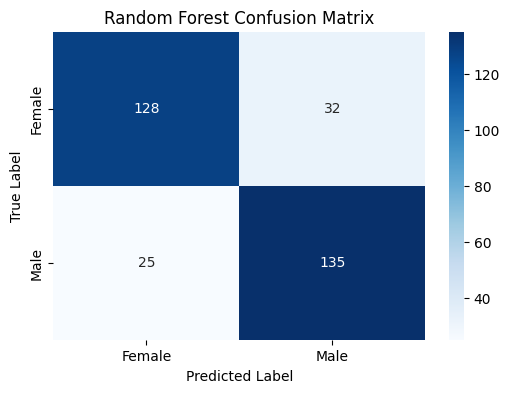

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to train Random Forest model and evaluate its performance
def train_random_forest(X_train, X_test, y_train, y_test):
    # Hyperparameter tuning for Random Forest using GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

    # Train the model with the best parameters found
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_rf.predict(X_test)

    # Evaluate accuracy and metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title("Random Forest Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Example usage
train_data_dir = "/content/extracted_folder/dataset1/train"  # Adjust this path accordingly
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_data_dir)

# Flatten images for model input
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Apply PCA for dimensionality reduction
X_train_pca, X_test_pca = apply_pca(X_train_flattened, X_test_flattened)

# Train and evaluate Random Forest model
train_random_forest(X_train_pca, X_test_pca, y_train, y_test)


# Gradient Boosting


Found 1600 images belonging to 2 classes.
Gradient Boosting Model Accuracy: 85.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       156
           1       0.85      0.87      0.86       164

    accuracy                           0.85       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.85      0.85      0.85       320



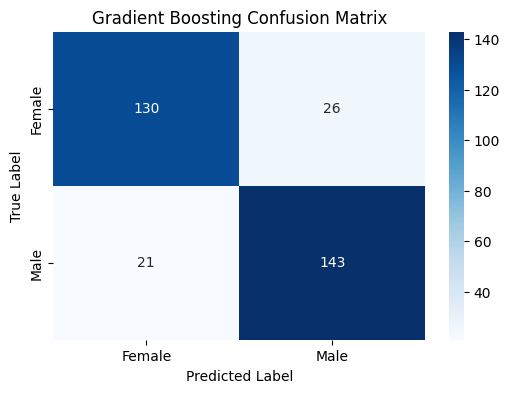

In [ ]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess the dataset
def load_and_preprocess_data(data_dir):
    # Initialize ImageDataGenerator for data augmentation and preprocessing
    datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Load training data from the directories
    train_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(64, 64),  # Resize all images to 64x64
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",  # Assuming binary classification (Male/Female)
        shuffle=True,
        seed=42
    )

    # Get image data and labels
    images, labels = [], []
    for i in range(len(train_generator)):
        img, lbl = next(train_generator)  # Use next() to get the next batch
        images.append(img)
        labels.append(lbl)

    # Concatenate the images and labels
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    # Flatten and encode the labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels.ravel())

    return images, encoded_labels

# Function to train Gradient Boosting model and evaluate its performance
def train_gradient_boosting(X_train, X_test, y_train, y_test):
    # Initialize the Gradient Boosting Classifier
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate accuracy and metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Gradient Boosting Model Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title("Gradient Boosting Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Main execution
train_data_dir = "/content/extracted_folder/dataset1/train"  # Adjust this path accordingly
X, y = load_and_preprocess_data(train_data_dir)

# Split dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten images for model input
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Train and evaluate Gradient Boosting model
train_gradient_boosting(X_train_flattened, X_test_flattened, y_train, y_test)


# Support Vector Machine

Found 1600 images belonging to 2 classes.
SVM Model Accuracy: 86.88%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       156
           1       0.85      0.90      0.88       164

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



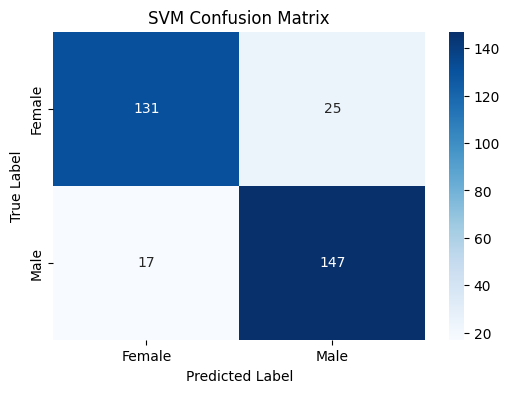

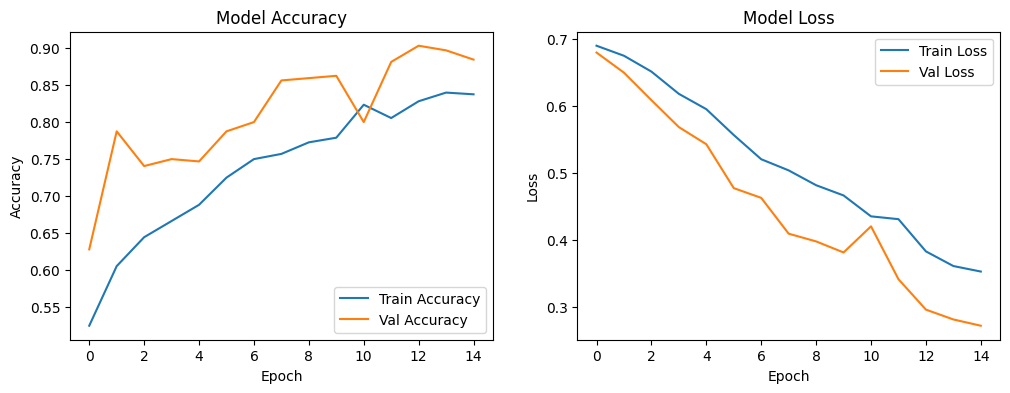

In [ ]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess the dataset
def load_and_preprocess_data(data_dir):
    # Initialize ImageDataGenerator for data augmentation and preprocessing
    datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Load training data from the directories
    train_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(64, 64),  # Resize all images to 64x64
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",  # Assuming binary classification (Male/Female)
        shuffle=True,
        seed=42
    )

    # Get image data and labels
    images, labels = [], []
    for i in range(len(train_generator)):
        img, lbl = next(train_generator)  # Use next() to get the next batch
        images.append(img)
        labels.append(lbl)

    # Concatenate the images and labels
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    # Flatten and encode the labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels.ravel())

    return images, encoded_labels

# Function to train SVM model and evaluate its performance
def train_svm(X_train, X_test, y_train, y_test):
    # Initialize the Support Vector Classifier
    model = SVC(kernel='linear', random_state=42)  # You can experiment with different kernels (linear, rbf, etc.)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate accuracy and metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title("SVM Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Main execution
train_data_dir = "/content/extracted_folder/dataset1/train"  # Adjust this path accordingly
X, y = load_and_preprocess_data(train_data_dir)

# Split dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten images for model input
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Train and evaluate SVM model
train_svm(X_train_flattened, X_test_flattened, y_train, y_test)


# CNN


Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - accuracy: 0.6504 - loss: 0.6201 - val_accuracy: 0.9000 - val_loss: 0.2664
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.8685 - loss: 0.3137 - val_accuracy: 0.9062 - val_loss: 0.2471
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.9259 - loss: 0.2227 - val_accuracy: 0.9156 - val_loss: 0.2117
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.9297 - loss: 0.2046 - val_accuracy: 0.9406 - val_loss: 0.1649
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9200 - loss: 0.1915 - val_accuracy: 0.9438 - val_loss: 0.1480
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.9348 - loss: 0.1855 - val_accuracy: 0.9156 - val_loss: 0.1905
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9265 - loss: 0.1799 - val_accuracy: 0.9500 - val_loss: 0.1483
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9440 - loss: 0.1436 - val_accuracy: 0.9406

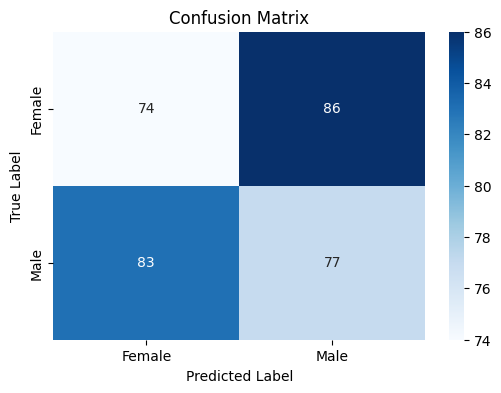

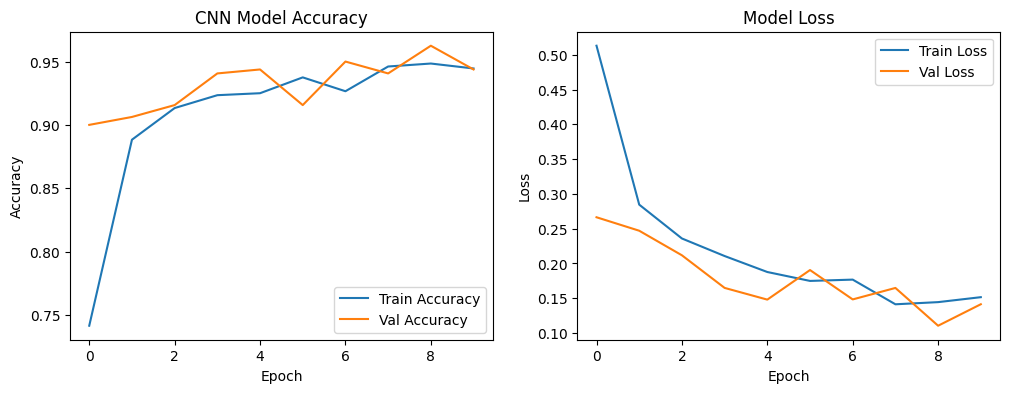

In [ ]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to load and preprocess the dataset
def load_and_preprocess_data(data_dir):
    datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        brightness_range=[0.8, 1.2],
        validation_split=0.2  # Adding validation split
    )

    train_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(128, 128),  # Using higher resolution
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",
        shuffle=True,
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        directory=data_dir,
        target_size=(128, 128),
        color_mode="rgb",
        batch_size=32,
        class_mode="binary",
        shuffle=True,
        subset='validation'
    )

    return train_generator, validation_generator

# Function to build a VGG16-based model
def build_vgg16_model():
    # Load the VGG16 model, excluding the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)  # Binary output layer

    # Compile the model
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to train and evaluate the model
def train_and_evaluate_model(train_generator, validation_generator):
    model = build_vgg16_model()

    # Train the model
    history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

    # Evaluate the model on validation set
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Generate confusion matrix and classification report
    y_pred = model.predict(validation_generator)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = validation_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot accuracy and loss curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Main execution
train_data_dir = "/content/extracted_folder/dataset1/train"  # Adjust path accordingly
train_generator, validation_generator = load_and_preprocess_data(train_data_dir)

# Train and evaluate the VGG16-based model
train_and_evaluate_model(train_generator, validation_generator)
